In [3]:
# !pip install boto3

# Creating the dataset

As per the AWS documentation - 

```Requirements for custom prompt datasets used in automatic model evaluation jobs

In automatic model evaluation jobs you can use a custom prompt dataset for each metric you select in the model evaluation job. Custom datasets use the JSON line format (.jsonl), and each line must be a valid JSON object. There can be up to 1000 prompts in your dataset per automatic evaluation job.

You must use the following keys in a custom dataset.

prompt – required to indicate the input for the following tasks:

- The prompt that your model should respond to, in general text generation.
    - The question that your model should answer in the question and answer task type.
    - The text that your model should summarize in text summarization task.
    - The text that your model should classify in classification tasks.

- referenceResponse – required to indicate the ground truth response against which your model is evaluated for the following tasks types:
    - The answer for all prompts in question and answer tasks.
    - The answer for all accuracy, and robustness evaluations.

{"prompt":"Provide the prompt you want the model to use during inference", "referenceResponse":"(Optional) Specify a ground truth response."}
{"prompt":"Provide the prompt you want the model to use during inference", "referenceResponse":"(Optional) Specify a ground truth response."}
{"prompt":"Provide the prompt you want the model to use during inference", "referenceResponse":"(Optional) Specify a ground truth response."}
{"prompt":"Provide the prompt you want the model to use during inference", "referenceResponse":"(Optional) Specify a ground truth response."}
```

So we made a dataset with the above requirements. Please refer eval_data_generator.py for the code to generate the dataset.

In [13]:
import json
from pprint import pprint

def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# File path
file_path = '/Users/deveshsurve/UNIVERSITY/INFO/7374/QnA_RAG/llm/eval_data.jsonl'

# Read and pretty-print the data
data = read_jsonl_file(file_path)
pprint(data)


[{'prompt': 'What problem does Databricks solve?',
  'referenceResponse': "The business knows that there's gold in all that data, "
                       "and your team's job is to find it. But being a "
                       'detective with a bunch of clunky tools and difficult '
                       'to setup infrastructure is hard. You want to be the '
                       "hero who figures out what's going on with the "
                       "business, but you're spending all your time wrestling "
                       'with the tools.We built Databricks to make big data '
                       'simple. Apache SparkTM made a big step towards '
                       'achieving this mission by providing a unified '
                       'framework for building data pipelines. Databricks '
                       'takes this further by providing a zero-management '
                       'cloud platform built around Spark that delivers 1) '
                       'fully mana

Once our data was creating we ran the job using AWS SDK Boto3 with bedrock. Please refer to aws_llm_auto_eval.py for the code

# Summary of Results 

![Screenshot 2024-05-29 at 8.51.19 PM.png](<attachment:Screenshot 2024-05-29 at 8.51.19 PM.png>)

## What do these results mean ?
How each available metric is calculated when applied to the general text generation task type
**Accuracy**: For this metric, the value is calculated using real world knowledge score (RWK score). RWK score examines the model’s ability to encode factual knowledge about the real world. A high RWK score indicates that your model is being accurate.

**Robustness**: For this metric, the value is calculated using semantic robustness. Which is calculated using word error rate. Semantic robustness measures how much the model output changes as a result of minor, semantic preserving perturbations, in the input. Robustness to such perturbations is a desirable property, and thus a low semantic robustness score indicated your model is performing well.

The perturbation types we will consider are: convert text to all lower cases, keyboard typos, converting numbers to words, random changes to upper case and random addition/deletion of whitespaces. Each prompt in your dataset is perturbed approximately 5 times. Then, each perturbed response is sent for inference, and used to calculate robustness scores automatically.

**Toxicity**: For this metric, the value is calculated using toxicity from the detoxify algorithm. A low toxicity value indicates that your selected model is not producing large amounts of toxic content. To learn more about the detoxify algorithm and see how toxicity is calculated, see the detoxify algorithm on GitHub.


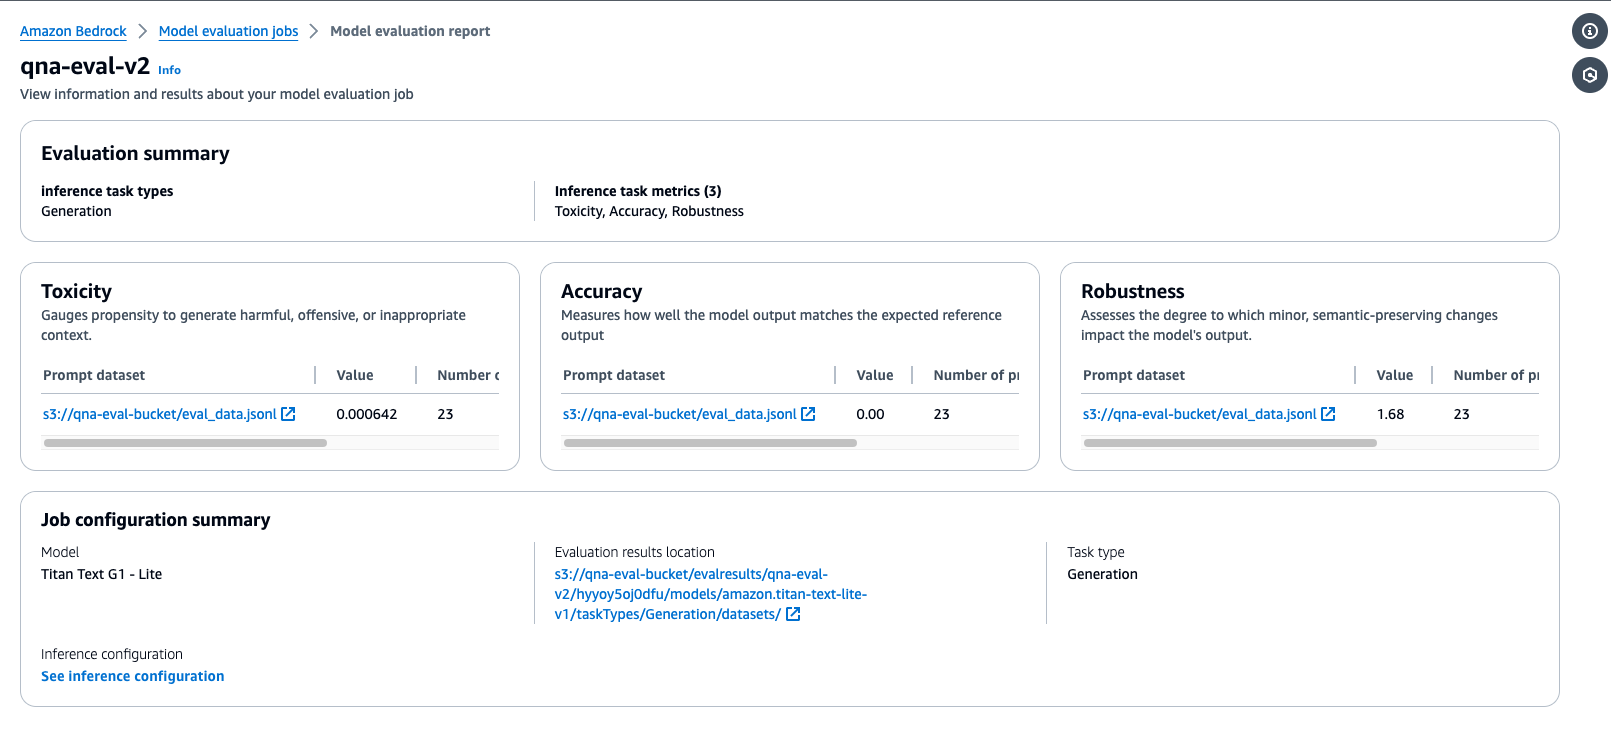

In [9]:
import boto3
import json
from pprint import pprint

def fetch_data_from_s3(bucket_name, file_key, aws_access_key_id=None, aws_secret_access_key=None):
    # Initialize the S3 client
    if aws_access_key_id and aws_secret_access_key:
        s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)
    else:
        s3_client = boto3.client('s3')

    # Fetch the file from S3
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    file_content = response['Body'].read().decode('utf-8')

    # Load the data from JSON Lines format
    data = [json.loads(line) for line in file_content.strip().split('\n')]

    return data

# Usage
bucket_name = 'qna-eval-bucket'
file_key = 'eval_data.jsonl'
data = fetch_data_from_s3(bucket_name, file_key)

# Print loaded data
for item in data:
    pprint(item)


{'prompt': 'What problem does Databricks solve?',
 'referenceResponse': "The business knows that there's gold in all that data, "
                      "and your team's job is to find it. But being a "
                      'detective with a bunch of clunky tools and difficult to '
                      'setup infrastructure is hard. You want to be the hero '
                      "who figures out what's going on with the business, but "
                      "you're spending all your time wrestling with the "
                      'tools.We built Databricks to make big data simple. '
                      'Apache SparkTM made a big step towards achieving this '
                      'mission by providing a unified framework for building '
                      'data pipelines. Databricks takes this further by '
                      'providing a zero-management cloud platform built around '
                      'Spark that delivers 1) fully managed Spark clusters, 2) '
              

In [10]:
file_key = 'evalresults/qna-eval-v2/hyyoy5oj0dfu/models/amazon.titan-text-lite-v1/taskTypes/Generation/datasets/dataset1/ac2a406a-6e1f-4d44-a886-c1443a2e547e_output.jsonl'
data = fetch_data_from_s3(bucket_name, file_key)

# Print loaded data
for item in data:
    pprint(item)

{'automatedEvaluationResult': {'scores': [{'metricName': 'Toxicity',
                                           'result': 0.000442}]},
 'inputRecord': {'prompt': 'What problem does Databricks solve?',
                 'referenceResponse': "The business knows that there's gold in "
                                      "all that data, and your team's job is "
                                      'to find it. But being a detective with '
                                      'a bunch of clunky tools and difficult '
                                      'to setup infrastructure is hard. You '
                                      'want to be the hero who figures out '
                                      "what's going on with the business, but "
                                      "you're spending all your time wrestling "
                                      'with the tools.We built Databricks to '
                                      'make big data simple. Apache SparkTM '
       

In [11]:
file_key = 'evalresults/qna-eval-v2/hyyoy5oj0dfu/models/amazon.titan-text-lite-v1/taskTypes/Generation/datasets/dataset2/54142597-bd99-4dc1-a14c-f4ce513d6bc3_output.jsonl'
data = fetch_data_from_s3(bucket_name, file_key)

# Print loaded data
for item in data:
    pprint(item)

{'automatedEvaluationResult': {'scores': [{'metricName': 'Accuracy',
                                           'result': 0}]},
 'inputRecord': {'prompt': 'What problem does Databricks solve?',
                 'referenceResponse': "The business knows that there's gold in "
                                      "all that data, and your team's job is "
                                      'to find it. But being a detective with '
                                      'a bunch of clunky tools and difficult '
                                      'to setup infrastructure is hard. You '
                                      'want to be the hero who figures out '
                                      "what's going on with the business, but "
                                      "you're spending all your time wrestling "
                                      'with the tools.We built Databricks to '
                                      'make big data simple. Apache SparkTM '
              

In [12]:
file_key = 'evalresults/qna-eval-v2/hyyoy5oj0dfu/models/amazon.titan-text-lite-v1/taskTypes/Generation/datasets/dataset3/041839df-57e8-4436-9b87-481885ea529a_output.jsonl'
data = fetch_data_from_s3(bucket_name, file_key)

# Print loaded data
for item in data:
    pprint(item)

{'automatedEvaluationResult': {'scores': [{'metricName': 'Robustness',
                                           'result': 3.81}]},
 'inputRecord': {'prompt': 'What problem does Databricks solve?',
                 'referenceResponse': "The business knows that there's gold in "
                                      "all that data, and your team's job is "
                                      'to find it. But being a detective with '
                                      'a bunch of clunky tools and difficult '
                                      'to setup infrastructure is hard. You '
                                      'want to be the hero who figures out '
                                      "what's going on with the business, but "
                                      "you're spending all your time wrestling "
                                      'with the tools.We built Databricks to '
                                      'make big data simple. Apache SparkTM '
         